<a href="https://colab.research.google.com/github/LariouchOussama/Twitter-Sentiment-Analysis/blob/main/TwitterBERT_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis using **BERT**



#**Sujet : analyse de sentiments**

Le traitement automatique de la langue est un domaine multidisciplinaire impliquant la
linguistique, l'informatique et l'intelligence artificielle. Il vise à créer des outils de traitement de
la langue naturelle pour diverses applications. Parmi ces applications, nous pouvons citer celles
qui relèvent du traitement des réseaux sociaux. Les sites de médias sociaux, tels que Twitter,
sont une source riche de nombreux types d'informations, notamment en matière de santé.
Ce projet consiste à développer des modèles de classification des sentiments (positive, negative
ou neutre) sur les réseaux sociaux avec trois architectures différentes (LSTM, BERT, et GPT),
et à évaluer le meilleur d’entre eux.


> Dataset est le site Kaggle:


**training.1600000.processed.noemoticon.csv**

In [2]:
# Importation des bibliothèques nécessaires
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import BertTokenizer
from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

import re
import nltk
from nltk.corpus import stopwords
#from google.colab import drive

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

# Afficher les dispositifs disponibles, configurer la croissance de la mémoire GPU et définir le GPU visible
print(device_lib.list_local_devices())
# Configurer la croissance de la mémoire GPU s'il y a des dispositifs GPU
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9893165589156729862
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2285964966209105995
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1143246090756939316
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


In [4]:
#drive.mount('/content/drive')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Importing the dataset

In [5]:
column_names = ['Sentiment', 'ID', 'Date', 'Query', 'Person', 'Content']

In [8]:
df = pd.read_csv('/kaggle/input/training1600000processednoemoticoncsv/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=column_names)

In [9]:
df.head()

,Sentiment,ID,Date,Query,Person,Content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
df.Sentiment.value_counts()

Sentiment
0    800000
4    800000
Name: count, dtype: int64

In [11]:
df['Sentiment'] = df['Sentiment'].replace(4,1)

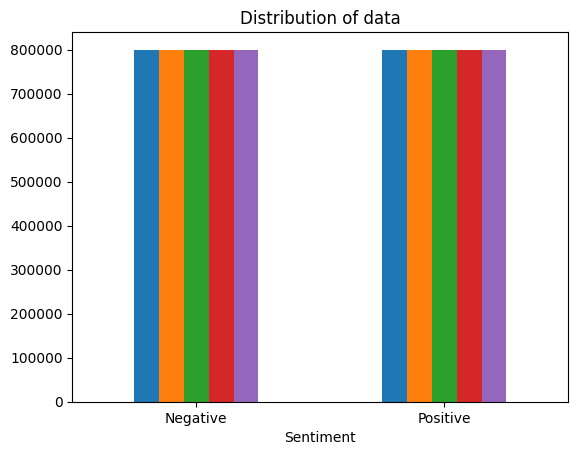

In [12]:


# Plotting the distribution for dataset.
ax = df.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
Content, sentiment = list(df['Content']), list(df['Sentiment'])



In [13]:
df.shape

(1600000, 6)

In [14]:
frames = [df.head(5000), df.tail(5000)]
df = pd.concat(frames)
df.shape


(10000, 6)

In [15]:

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

def assign_labels_2(label):
    if label == 1:
        return 'positive'
    elif label == 0:
        return 'negative'

In [16]:

num_labels = 2

X = df['Content'].apply(preprocess_text)
y = df['Sentiment'].apply(assign_labels_2)

In [17]:
sentiment_counts = y.value_counts()
fig = px.bar(sentiment_counts, x=sentiment_counts.index, y=sentiment_counts.values, color=sentiment_counts.index)
fig.update_layout(title="Sentiment Distribution")
fig.show()


In [18]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
validation_num = 1000

X_validation, X_train = X_train[:validation_num], X_train[validation_num:]
y_validation, y_train = y_train[:validation_num], y_train[validation_num:]

In [20]:
X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape

((7000,), (1000,), (2000,), (7000,), (1000,), (2000,))

In [21]:
# Utilisation du GPU et chargement du tokenizer et du modèle BERT

with tf.device('GPU'):
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
def create_input_tensors(input_X, tokenizer):

    input_ids = []
    attention_masks = []

    for text in input_X:
        tokens = tokenize_text(text, tokenizer)
        input_ids.append(tokens['input_ids'][0])
        attention_masks.append(tokens['attention_mask'][0])

    input_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)

    return {'input_ids': input_ids, 'attention_mask': attention_masks}


def tokenize_text(text, tokenizer):
    tokens = tokenizer.encode_plus(text,
                                   max_length=128,
                                   truncation=True,
                                   padding='max_length',
                                   add_special_tokens=True,
                                   return_attention_mask=True,
                                   return_tensors='tf')
    return tokens


def convert_labels_to_one_hot(labels, num_classes):
    label_mapping = {'positive': 1,
                     'negative': 0}
    labels = [label_mapping[label] for label in labels]

    return tf.keras.utils.to_categorical(labels, num_classes=num_classes)


In [23]:

new_train_X = create_input_tensors(X_train, bert_tokenizer)
new_train_y = convert_labels_to_one_hot(y_train, num_labels)

new_validation_X = create_input_tensors(X_validation, bert_tokenizer)
new_validation_y = convert_labels_to_one_hot(y_validation, num_labels)

new_test_X = create_input_tensors(X_test, bert_tokenizer)
new_test_y = convert_labels_to_one_hot(y_test, num_labels)

In [24]:

with tf.device('GPU'):

  epochs = 3

  bert_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
                loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy')])

  bert_model_history = bert_model.fit(new_train_X,
                                      new_train_y,
                                      batch_size=32,
                                      epochs=epochs,
                                      validation_data=(new_validation_X, new_validation_y))

Epoch 1/3
219/219 [==============================] - 233s 833ms/step - loss: 0.5665 - accuracy: 0.7047 - val_loss: 0.4939 - val_accuracy: 0.7640
Epoch 2/3
219/219 [==============================] - 184s 838ms/step - loss: 0.4181 - accuracy: 0.8153 - val_loss: 0.5525 - val_accuracy: 0.7320
Epoch 3/3
219/219 [==============================] - 183s 838ms/step - loss: 0.2715 - accuracy: 0.8963 - val_loss: 0.6395 - val_accuracy: 0.7680


In [25]:
train_loss_history = bert_model_history.history['loss']
validation_loss_history = bert_model_history.history['val_loss']

train_acc_history = bert_model_history.history['accuracy']
validation_acc_history = bert_model_history.history['val_accuracy']

In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=train_loss_history, mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=validation_loss_history, mode='lines+markers', name='Validation Loss'))

fig.update_layout(title="Bert Loss",
                  xaxis_title="Epochs",
                  yaxis_title="Loss")
fig.show()

In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=train_acc_history, mode='lines+markers', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=validation_acc_history, mode='lines+markers', name='Validation Accuracy'))

fig.update_layout(title="Bert Accuracy",
                  xaxis_title="Epochs",
                  yaxis_title="Accuracy")
fig.show()

In [28]:
test_predictions = bert_model.predict(new_test_X)
predicted_labels = np.argmax(test_predictions.logits, axis=1)

test_labels_1d = np.argmax(new_test_y, axis=1)

63/63 [==============================] - 21s 287ms/step


In [29]:
print(classification_report(test_labels_1d, predicted_labels))

              precision    recall  f1-score   support

           0       0.75      0.82      0.79      1012
           1       0.80      0.72      0.76       988

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



In [30]:
confusion_matrix = confusion_matrix(test_labels_1d, predicted_labels)

heatmap = go.Heatmap(
    z=confusion_matrix,
    x=['Negative', 'Positive'],
    y=['Negative', 'Positive'],
    colorscale='Blues',
    reversescale=True,
)

layout = go.Layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted'),
    yaxis=dict(title='True'),
)

fig = go.Figure(data=[heatmap], layout=layout)
fig.show()